# Tutorial 12 - TensorFlow Serving

[![View notebook on Github](https://img.shields.io/static/v1.svg?logo=github&label=Repo&message=View%20On%20Github&color=lightgrey)](https://github.com/avakanski/Fall-2024-Applied-Data-Science-with-Python/blob/main/docs/Lectures/Tutorials/Tutorial_12-TensorFlow_Serving/Tutorial_12-TensorFlow_Serving.ipynb)
[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/avakanski/Fall-2024-Applied-Data-Science-with-Python/blob/main/docs/Lectures/Tutorials/Tutorial_12-TensorFlow_Serving/Tutorial_12-TensorFlow_Serving.ipynb)

<a id='top'></a>

<a id='top'></a>

**TensorFlow Serving** is a specialized library for deploying machine learning models developed with TensorFlow. It facilitates serving TensorFlow models in production via REST APIs or gRPC interfaces. Its key features include model versioning, automatic request batching, and support for canary deployments, simplifying model management and deployment processes.

By using TensorFlow Serving, users can deploy TensorFlow models in production without needing to manage the underlying infrastructure or serving complexities. This high-performance, flexible serving system is designed specifically for production use. It enables seamless deployment of new algorithms and experiments while maintaining a consistent server architecture and APIs. While TensorFlow Serving is optimized for TensorFlow models, it can be extended to serve other model types as well.

TensorFlow Serving uses Docker to simplify model deployment by providing pre-built images that bundle all dependencies, ensuring consistency across development, testing, and production environments. Docker’s lightweight containers offer isolation and portability, allowing TensorFlow Serving to run efficiently on various platforms without interference with other applications. It supports horizontal scaling, easy updates, and seamless integration with CI/CD pipelines and orchestration tools like Kubernetes. By leveraging Docker, TensorFlow Serving enables resource-efficient, reliable, and flexible model serving while minimizing setup and maintenance complexities.

## Docker 

Docker is an open-source platform that enables the packaging of applications and their dependencies into lightweight, portable, and isolated units called containers. By bundling everything needed to run an application, containers ensure consistent behavior across development, testing, and production environments. Unlike virtual machines, containers share the host operating system, making them faster and more resource-efficient. Docker streamlines deployment, supports scalability, and integrates seamlessly with CI/CD pipelines, making it a preferred tool in modern software development and cloud computing.

To install Docker, use:

* Linux bash script: `docker pull tensorflow/serving`
* In Windows, use this [link]( https://docs.docker.com/desktop/setup/install/windows-install/) to download and install `Docker for Windows`, which integrates with WSL2.

## ML Model Creation

In [1]:
# Create a simple NN to predict labels for MNIST images
import tensorflow as tf
import os
# Load MNIST dataset
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize the data
x_train, x_test = x_train / 255.0, x_test / 255.0

# Build the model
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),  # Flatten the 28x28 images
    tf.keras.layers.Dense(128, activation='relu'),  # Hidden layer
    tf.keras.layers.Dropout(0.2),                  # Regularization
    tf.keras.layers.Dense(10, activation='softmax') # Output layer for 10 classes
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
model.fit(x_train, y_train, epochs=5)

# Evaluate the model
loss, accuracy = model.evaluate(x_test, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")


Epoch 1/5


c:\Users\LZ\anaconda3\envs\tensorflow\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 879us/step - accuracy: 0.8566 - loss: 0.4912
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 855us/step - accuracy: 0.9572 - loss: 0.1442
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 821us/step - accuracy: 0.9676 - loss: 0.1079
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 843us/step - accuracy: 0.9749 - loss: 0.0832
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 863us/step - accuracy: 0.9769 - loss: 0.0737
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step - accuracy: 0.9715 - loss: 0.0927
Test Loss: 0.07450953125953674
Test Accuracy: 0.9767000079154968


### Save the ML Model

To save the model, the current version of TensorFlow Serving library works with the `model.export()`, whereas `model.save()` or `tf.saved_model.save()` may generate errors. 

To save your model create a folder and a subfolder as shown below. The folder's name is `my_model` and the 
subfolder's name for the version control purpose is `1` (`/my_model/1`). This is a default format required by TensorFlow Serving for model deployment.

<img height=270 width=500 src="images/1.png">

In [ ]:
# Export the trained ML model to the folder my_model/1
import os
current_folder = os.getcwd()
current_folder = current_folder+'/my_model/1'
model.export(current_folder)

## TensorFlow Serving with Docker

To start TensorFlow Serving, use this command in WSL2 to deploy the model in Docker:

    docker run -p 8501:8501 --name=tf_serving_my_model   --mount 
    type=bind,source=/mnt/c/Users/LZ/Desktop/tf_serving/my_model,target=/models/my_model   -e MODEL_NAME=my_model -t tensorflow/serving

As the screenshot below shows, the main folder is `tf_serving`, and the saved model's main folder is `my_model`. You can ignore the `1` subfolder inside the `my_model` folder in this command, since the TensorFlow Serving system will automatically detect the subfolder for version control purpose.

<img height=40 width=2000 src="images/2.png">

When the TensorFlow Serving is configured correctly, it will show the following status:

<img height=500 width=1000 src="images/3.png">

TensorFlow Serving showing on the Docker Desktop on Windows.

<img height=400 width=1000 src="images/4.png">

## Send a Request with the REST API

Select a test image from the MNIST dataset.

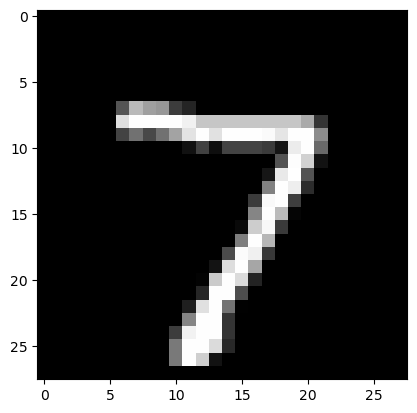

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot  as plt
import requests
# Load MNIST test data
(_, _), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_test = x_test / 255.0  # Normalize the test data

# Select a single test image
test_image = x_test[0].tolist()  # Convert the first test image to a list

plt.imshow(x_test[0], cmap="gray")

Construct the URL, e.g., here we use `localhost:8501` on the local computer. In the URL link make sure to configure the correct folder name where you saved your model (`my_model`).

In [3]:
url = "http://localhost:8501/v1/models/my_model:predict"

# Create input data for testing (batch of one image)
input_data = {
    "instances": [test_image]
}

# Send the POST request to TensorFlow Serving
response = requests.post(url, json=input_data)

# Parse the response
predictions = response.json().get("predictions", [])
predicted_label = np.argmax(predictions[0])
print('The predicted number is: ',predicted_label)

The predicted number is:  7


## References

1. TensorFlow, "Serving Guide." *TensorFlow TFX Documentation*, available at [https://www.tensorflow.org/tfx/guide/serving](https://www.tensorflow.org/tfx/guide/serving). 
2. TensorFlow, "Serving a Simple Model via REST." TensorFlow TFX Documentation, available at [https://www.tensorflow.org/tfx/tutorials/serving/rest_simple](https://www.tensorflow.org/tfx/tutorials/serving/rest_simple).
3. Neptune AI. "How to Serve Machine Learning Models with TensorFlow Serving and Docker." available at [https://neptune.ai/blog/how-to-serve-machine-learning-models-with-tensorflow-serving-and-docker](https://neptune.ai/blog/how-to-serve-machine-learning-models-with-tensorflow-serving-and-docker).

[BACK TO TOP](#top)